C:\Users\kumar\AppData\Local\Temp\ipykernel_20492\3008544703.py:13: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



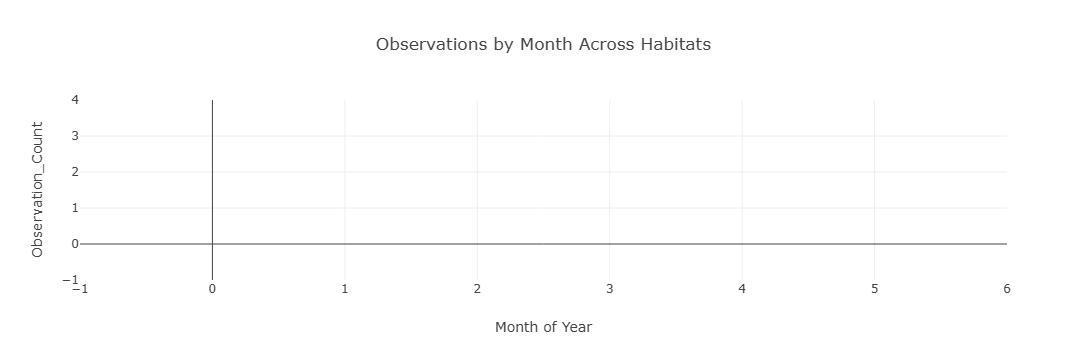

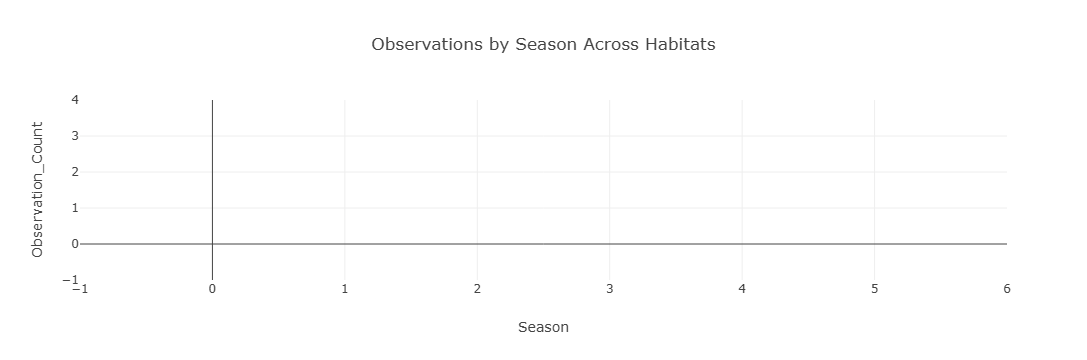

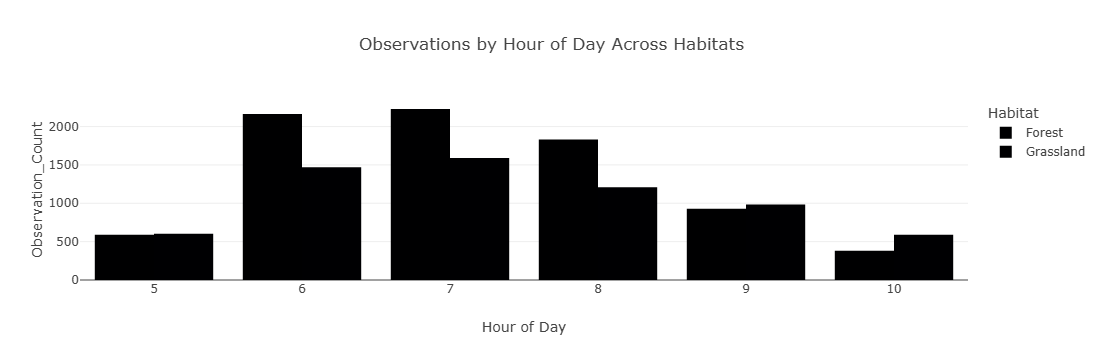

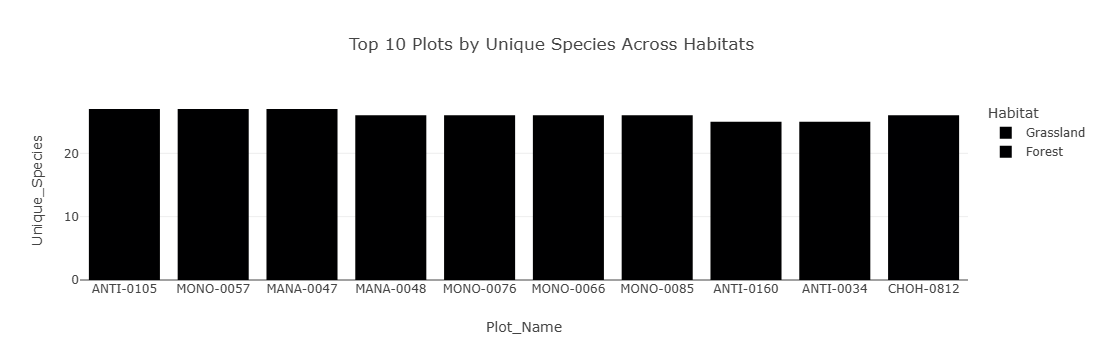

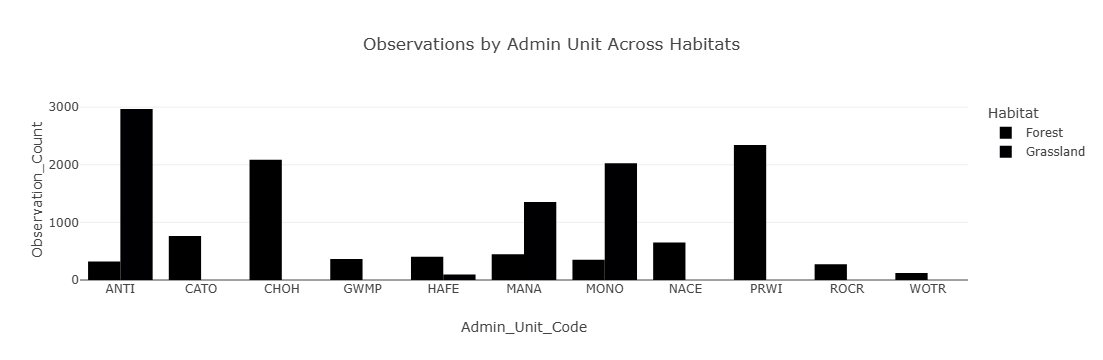

Unique Species by Habitat:


,Habitat,Unique_Species
0,Forest,108
1,Grassland,107


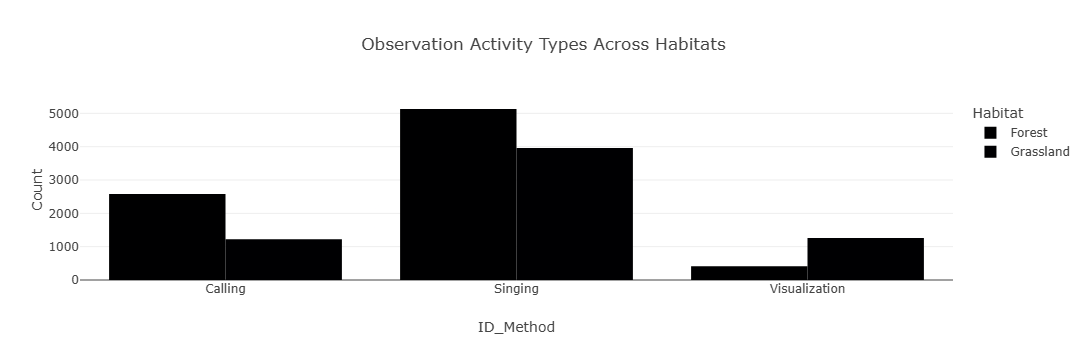

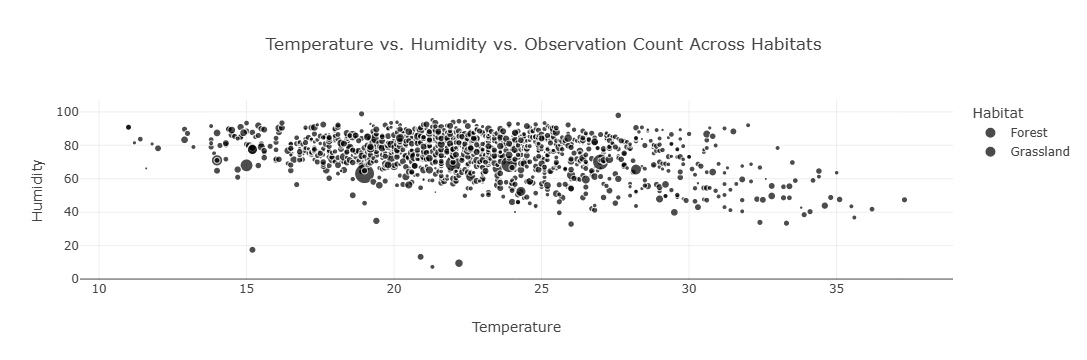

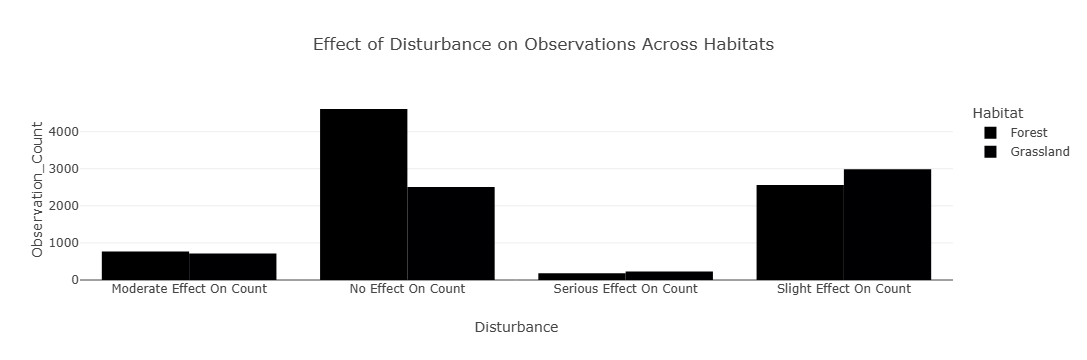

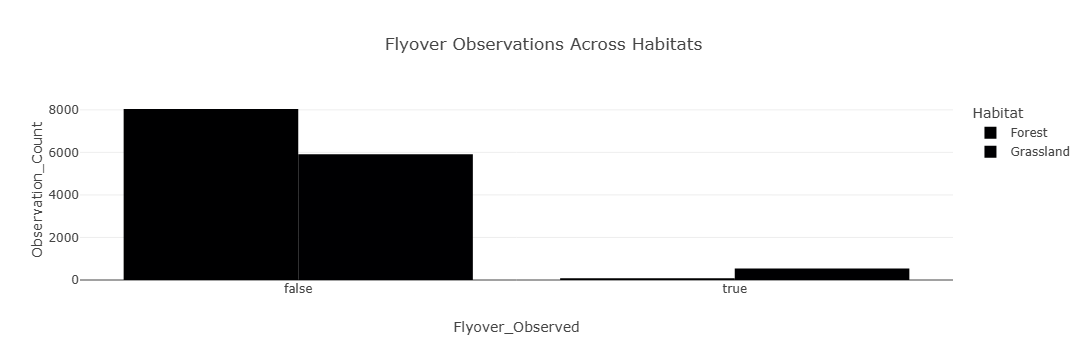

Watchlist Species by Habitat:


,Common_Name,Habitat,Count
0,Blue-Winged Warbler,Forest,1
1,Cerulean Warbler,Forest,7
2,Kentucky Warbler,Forest,1
3,Kentucky Warbler,Grassland,1
4,Prairie Warbler,Forest,7
5,Prairie Warbler,Grassland,18
6,Red-Headed Woodpecker,Forest,1
7,Willow Flycatcher,Grassland,2
8,Wood Thrush,Forest,275
9,Wood Thrush,Grassland,19


Regional Stewardship Species by Habitat:


,Common_Name,Habitat,Count
0,Acadian Flycatcher,Forest,402
1,Acadian Flycatcher,Grassland,26
2,Belted Kingfisher,Forest,3
3,Belted Kingfisher,Grassland,1
4,Blue Grosbeak,Grassland,14
5,Brown Thrasher,Forest,6
6,Brown Thrasher,Grassland,15
7,Carolina Chickadee,Forest,258
8,Carolina Chickadee,Grassland,88
9,Chimney Swift,Forest,12


In [13]:


import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta, time



def load_and_concatenate_data(file_path, habitat):
    xl = pd.ExcelFile(file_path)
    dfs = [pd.read_excel(xl, sheet_name=sheet) for sheet in xl.sheet_names]
    df = pd.concat(dfs, ignore_index=True)
    df['Habitat'] = habitat
    return df

grassland_file = "C:/Users/kumar/Downloads/Bird_Monitoring_Data_GRASSLAND.XLSX"
forest_file = "C:/Users/kumar/Downloads/Bird_Monitoring_Data_FOREST.XLSX"

grassland_df = load_and_concatenate_data(grassland_file, 'Grassland')
forest_df = load_and_concatenate_data(forest_file, 'Forest')

# Combine datasets
df = pd.concat([grassland_df, forest_df], ignore_index=True).copy()  # Explicit copy to avoid view issues
df.head()


def clean_data(df):
    # Create a copy to ensure we're working on a new DataFrame
    df = df.copy()
    
    # Handle missing values
    df.loc[:, 'Sub_Unit_Code'] = df['Sub_Unit_Code'].fillna('NA')
    df.loc[:, 'Distance'] = df['Distance'].fillna('Not Recorded')
    df.loc[:, 'Sex'] = df['Sex'].fillna('Undetermined')
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['Plot_Name', 'Date', 'Start_Time', 'Common_Name', 'ID_Method', 'Distance', 'Sex'])
    
    # Convert Date from Excel serial to datetime
    def excel_date_to_datetime(serial):
        if pd.isna(serial) or not isinstance(serial, (int, float)):
            return pd.NaT
        return pd.to_datetime('1899-12-30') + pd.to_timedelta(serial, unit='D')
    
    df.loc[:, 'Date'] = df['Date'].apply(excel_date_to_datetime)
    df.loc[:, 'Month'] = df['Date'].dt.month
    df.loc[:, 'Season'] = df['Month'].map({
        1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall',
        11: 'Fall', 12: 'Winter'
    })
    
    # Convert Start_Time and End_Time to floats (fraction of day)
    def time_to_float(time_val):
        if pd.isna(time_val):
            return None
        if isinstance(time_val, (int, float)):
            return float(time_val)
        if isinstance(time_val, time):
            total_seconds = time_val.hour * 3600 + time_val.minute * 60 + time_val.second
            return total_seconds / (24 * 3600)  # Convert to fraction of day
        try:
            return float(time_val)
        except (ValueError, TypeError):
            return None
    
    # Use .loc to avoid SettingWithCopyWarning
    df.loc[:, 'Start_Time'] = df['Start_Time'].apply(time_to_float)  # Line 89
    df.loc[:, 'End_Time'] = df['End_Time'].apply(time_to_float)
    
    # Convert numerical columns
    df.loc[:, 'Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
    df.loc[:, 'Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')
    
    # Convert boolean columns using .loc to avoid SettingWithCopyWarning
    bool_cols = ['Flyover_Observed', 'PIF_Watchlist_Status', 'Regional_Stewardship_Status', 
                 'Initial_Three_Min_Cnt']
    for col in bool_cols:
        df.loc[:, col] = df[col].map({'true': True, 'false': False, True: True, False: False})  # Line 95
    
    # Standardize string columns
    str_cols = ['Common_Name', 'Scientific_Name', 'ID_Method', 'Distance', 'Sky', 'Wind', 'Disturbance']
    for col in str_cols:
        if df[col].dtype == "object":
            df.loc[:, col] = df[col].str.strip().str.title()
    
    # Drop unnecessary columns
    df = df.drop(columns=['Sub_Unit_Code'], errors='ignore')
    return df

cleaned_df = clean_data(df)
cleaned_df.to_csv('cleaned_bird_monitoring_combined.csv', index=False)
cleaned_df.head()



def perform_analysis(df):
    analysis_results = {}
    
    # Temporal Analysis
    monthly_counts = df.groupby(['Month', 'Habitat'])['Common_Name'].count().reset_index(name='Observation_Count')
    seasonal_counts = df.groupby(['Season', 'Habitat'])['Common_Name'].count().reset_index(name='Observation_Count')
    time_counts = df.groupby([df['Start_Time'].apply(lambda x: int(float(x) * 24) if pd.notna(x) else -1), 'Habitat'])['Common_Name'].count().reset_index(name='Observation_Count')
    time_counts = time_counts.rename(columns={'Start_Time': 'Hour_of_Day'})
    analysis_results['monthly_counts'] = monthly_counts
    analysis_results['seasonal_counts'] = seasonal_counts
    analysis_results['time_counts'] = time_counts
    
    # Spatial Analysis
    plot_species = df.groupby(['Plot_Name', 'Habitat'])['Scientific_Name'].nunique().reset_index(name='Unique_Species')
    admin_unit_counts = df.groupby(['Admin_Unit_Code', 'Habitat'])['Common_Name'].count().reset_index(name='Observation_Count')
    analysis_results['plot_species'] = plot_species
    analysis_results['admin_unit_counts'] = admin_unit_counts
    
    # Species Analysis
    species_diversity = df.groupby('Habitat')['Scientific_Name'].nunique().reset_index(name='Unique_Species')
    activity_counts = df.groupby(['ID_Method', 'Habitat'])['Common_Name'].count().reset_index(name='Count')
    sex_ratio = df.groupby(['Common_Name', 'Sex', 'Habitat'])['Common_Name'].count().unstack(fill_value=0).reset_index()
    analysis_results['species_diversity'] = species_diversity
    analysis_results['activity_counts'] = activity_counts
    analysis_results['sex_ratio'] = sex_ratio
    
    # Environmental Conditions
    env_corr = df.groupby(['Temperature', 'Humidity', 'Habitat'])['Common_Name'].count().reset_index(name='Observation_Count')
    disturbance_effect = df.groupby(['Disturbance', 'Habitat'])['Common_Name'].count().reset_index(name='Observation_Count')
    analysis_results['env_corr'] = env_corr
    analysis_results['disturbance_effect'] = disturbance_effect
    
    # Distance and Behavior
    distance_counts = df.groupby(['Common_Name', 'Distance', 'Habitat'])['Common_Name'].count().unstack(fill_value=0).reset_index()
    flyover_counts = df.groupby(['Flyover_Observed', 'Habitat'])['Common_Name'].count().reset_index(name='Observation_Count')
    analysis_results['distance_counts'] = distance_counts
    analysis_results['flyover_counts'] = flyover_counts
    
    # Observer Trends
    observer_counts = df.groupby(['Observer', 'Habitat'])['Common_Name'].count().reset_index(name='Observation_Count')
    observer_species = df.groupby(['Observer', 'Habitat'])['Scientific_Name'].nunique().reset_index(name='Unique_Species')
    visit_counts = df.groupby(['Visit', 'Habitat'])['Scientific_Name'].nunique().reset_index(name='Unique_Species')
    analysis_results['observer_counts'] = observer_counts
    analysis_results['observer_species'] = observer_species
    analysis_results['visit_counts'] = visit_counts
    
    # Conservation Insights
    watchlist_species = df[df['PIF_Watchlist_Status'] == True].groupby(['Common_Name', 'Habitat'])['Common_Name'].count().reset_index(name='Count')
    stewardship_species = df[df['Regional_Stewardship_Status'] == True].groupby(['Common_Name', 'Habitat'])['Common_Name'].count().reset_index(name='Count')
    aou_counts = df.groupby(['AOU_Code', 'Habitat'])['Common_Name'].count().reset_index(name='Count')
    analysis_results['watchlist_species'] = watchlist_species
    analysis_results['stewardship_species'] = stewardship_species
    analysis_results['aou_counts'] = aou_counts
    
    return analysis_results

analysis_results = perform_analysis(cleaned_df)

# Save analysis results
for key, value in analysis_results.items():
    if isinstance(value, pd.DataFrame):
        value.to_csv(f'bird_analysis_{key}.csv', index=False)



# Temporal Analysis: Observations by Month
fig_monthly = px.bar(analysis_results['monthly_counts'], x='Month', y='Observation_Count', color='Habitat', 
                     barmode='group', title='Observations by Month Across Habitats', 
                     labels={'Month': 'Month of Year'})
fig_monthly.show()

# Temporal Analysis: Observations by Season
fig_seasonal = px.bar(analysis_results['seasonal_counts'], x='Season', y='Observation_Count', color='Habitat', 
                      barmode='group', title='Observations by Season Across Habitats')
fig_seasonal.show()

# Temporal Analysis: Observations by Hour of Day
fig_time = px.bar(analysis_results['time_counts'], x='Hour_of_Day', y='Observation_Count', color='Habitat', 
                  barmode='group', title='Observations by Hour of Day Across Habitats', 
                  labels={'Hour_of_Day': 'Hour of Day'})
fig_time.show()

# Spatial Analysis: Top 10 Plots by Unique Species
top_plots = analysis_results['plot_species'].sort_values('Unique_Species', ascending=False).head(10)
fig_plot_species = px.bar(top_plots, x='Plot_Name', y='Unique_Species', color='Habitat', 
                          title='Top 10 Plots by Unique Species Across Habitats')
fig_plot_species.show()

# Spatial Analysis: Observations by Admin Unit
fig_admin_unit = px.bar(analysis_results['admin_unit_counts'], x='Admin_Unit_Code', y='Observation_Count', 
                        color='Habitat', barmode='group', title='Observations by Admin Unit Across Habitats')
fig_admin_unit.show()

# Species Analysis: Unique Species by Habitat
print("Unique Species by Habitat:")
display(analysis_results['species_diversity'])

# Species Analysis: Observation Activity Types
fig_activity = px.bar(analysis_results['activity_counts'], x='ID_Method', y='Count', color='Habitat', 
                      barmode='group', title='Observation Activity Types Across Habitats')
fig_activity.show()

# Environmental Conditions: Temperature vs. Humidity
fig_env = px.scatter(analysis_results['env_corr'], x='Temperature', y='Humidity', size='Observation_Count', 
                     color='Habitat', title='Temperature vs. Humidity vs. Observation Count Across Habitats')
fig_env.show()

# Environmental Conditions: Disturbance Effect
fig_disturbance = px.bar(analysis_results['disturbance_effect'], x='Disturbance', y='Observation_Count', 
                         color='Habitat', barmode='group', title='Effect of Disturbance on Observations Across Habitats')
fig_disturbance.show()

# Distance and Behavior: Flyover Observations
fig_flyover = px.bar(analysis_results['flyover_counts'], x='Flyover_Observed', y='Observation_Count', 
                     color='Habitat', barmode='group', title='Flyover Observations Across Habitats')
fig_flyover.show()

# Conservation Insights: Watchlist and Stewardship Species
print("Watchlist Species by Habitat:")
display(analysis_results['watchlist_species'])
print("Regional Stewardship Species by Habitat:")
display(analysis_results['stewardship_species'])

